In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn import linear_model


## Predictor Variables

In [2]:
# Commodity Prices
dfCommodity = pd.read_csv('../data/commodityPrices.csv')
dfCommodity['date'] = pd.to_datetime(dfCommodity['date'])
dfCommodity = dfCommodity.set_index('date').sort_index()

# Wind Generation
dfWind = pd.read_csv('../data/MISOWindGeneration.csv')
dfWind['date'] = pd.to_datetime(dfWind['date'])
dfWind = dfWind.set_index('date').sort_index()

# Demand
dfLoad = pd.read_csv('../data/MISOActualLoad.csv')
dfLoad['Market Day'] = pd.to_datetime(dfLoad['Market Day'])
dfLoad = dfLoad.set_index('Market Day').sort_index()
dfLoad.index.names = ['date']
dfLoadActual = dfLoad[['Central ActualLoad (MWh)', 'East ActualLoad (MWh)', 'MISO ActualLoad (MWh)', 'Midwest ISO ActualLoad (MWh)', 'North ActualLoad (MWh)', 'South ActualLoad (MWh)', 'West ActualLoad (MWh)']]
dfLoadActual = dfLoadActual.fillna(0)    # Handle NaN

In [3]:
# Merge into a single DataFrame
dfX = pd.merge(dfCommodity, dfWind, left_index=True, right_index=True)
dfX = pd.merge(dfX, dfLoadActual, left_index=True, right_index=True)
dfX.head()

,Central Appalachia,Northern Appalachia,Illinois Basin,Powder River Basin,Uinta Basin,NgPrice,windGenerationMWh,Central ActualLoad (MWh),East ActualLoad (MWh),MISO ActualLoad (MWh),Midwest ISO ActualLoad (MWh),North ActualLoad (MWh),South ActualLoad (MWh),West ActualLoad (MWh)
date,,,,,,,,,,,,,,
2009-07-06,53.333333,51.166667,44,9,44.5,3.355000,325.927083,21654.299167,28127.989583,0,62493.192500,0,0,12710.903750
2009-07-07,53.500000,52.000000,44,9,44.5,3.300000,511.056250,22956.574167,27699.694167,0,63508.234167,0,0,12851.965833
2009-07-08,53.500000,52.000000,44,9,44.5,3.298571,728.637083,22402.212500,27335.640833,0,62295.661250,0,0,12557.807917
2009-07-09,53.500000,52.000000,44,9,44.5,3.297143,1716.773333,23165.527500,28635.972917,0,64392.903333,0,0,12591.402917
2009-07-10,53.500000,52.000000,44,9,44.5,3.295714,837.547917,23676.907917,29816.782083,0,66701.584583,0,0,13207.894583


## Response Variable

In [32]:
# dfMiso = pd.read_hdf('../data/LMP.h5')
print dfLoad.head()
print dfLoad.tail()

            Central ActualLoad (MWh)  Central MTLF (MWh)  \
date                                                       
2009-07-06              21654.299167        21574.958333   
2009-07-07              22956.574167        23193.583333   
2009-07-08              22402.212500        23309.416667   
2009-07-09              23165.527500        23031.166667   
2009-07-10              23676.907917        24905.166667   

            East ActualLoad (MWh)  East MTLF (MWh)  MISO ActualLoad (MWh)  \
date                                                                        
2009-07-06           28127.989583     29054.750000                    NaN   
2009-07-07           27699.694167     28019.625000                    NaN   
2009-07-08           27335.640833     27693.458333                    NaN   
2009-07-09           28635.972917     28576.083333                    NaN   
2009-07-10           29816.782083     30258.333333                    NaN   

            MISO ISO MTLF (MWh)  MISO M

In [5]:
# tsY = dfMiso.ix['AECI.AMMO']['meanPrice']    # converted to Pandas.Series
# tsY.index = pd.to_datetime(tsY.index)
# dfY = pd.DataFrame(tsY)

In [4]:
dfMiso = pd.read_hdf('../data/LMP-ACEI_AMMO.h5','lmp')
dfMiso.index = pd.to_datetime(dfMiso.index)

tsY = dfMiso['meanPrice']     # converted to Pandas.Series
tsY.index = pd.to_datetime(tsY.index)
dfY = pd.DataFrame(tsY)

## Data Prep before Regression

In [5]:
df = pd.merge(dfY, dfX, left_index=True, right_index=True, how='inner')
df = df[:'2013-09-01']

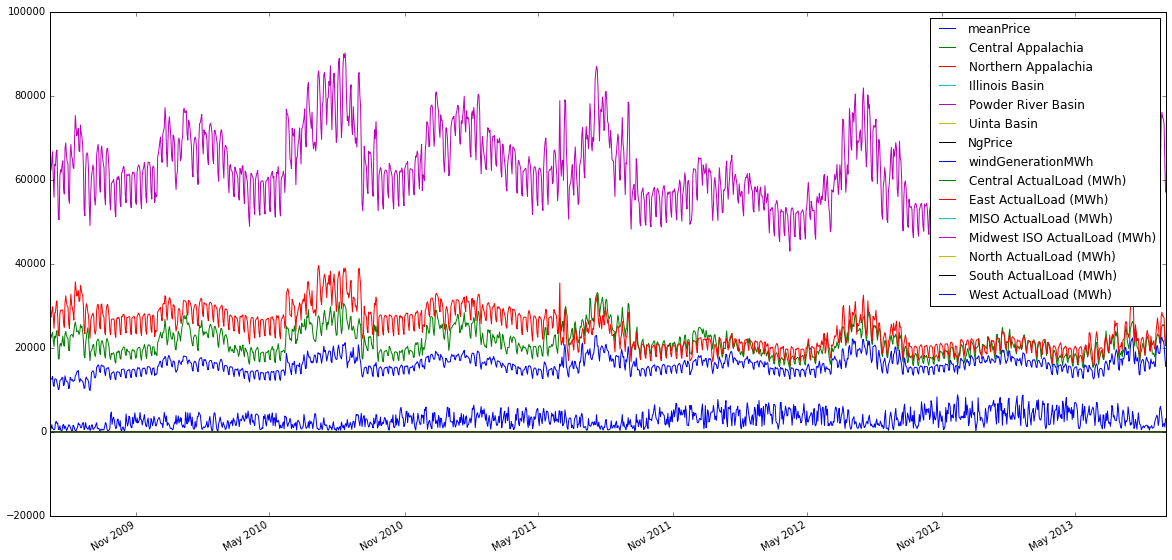

In [6]:
df.plot()

## Random Forest Regression (Single Node)

In [7]:
%%time

from sklearn.cross_validation import train_test_split
from sklearn import grid_search
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy import stats


# Outlier Removal: Very low LMP
df2 = df.copy()
df2 = df2[df2['meanPrice'] > 15]


# Log Transform
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate by tiny amount to avoid np.log(0)
df2['Northern Appalachia'] = np.log(df2['Northern Appalachia'] + 0.1)
df2['Illinois Basin'] = np.log(df2['Illinois Basin'] + 0.1)
df2['Uinta Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Powder River Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Central Appalachia'] = np.log(df2['Central Appalachia'] + 0.1)


# Outlier Removal: 2-sd
df2 = df2[(np.abs(stats.zscore(df2['meanPrice'])) < 2)]

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch
params = {
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [30,50,75,100],
        'max_depth': [None,1,2,3,5],
        'min_samples_split': [2,3,5]
}
clf = grid_search.GridSearchCV(RandomForestRegressor(n_jobs=3), params, cv=5, n_jobs=1)
fit = clf.fit(X_train, y_train)


# Best Estimator
rf = fit.best_estimator_


# Metrics
print 'Best Params: ', fit.best_params_
print 'Best Score: ', fit.best_score_
print
preds = rf.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Feature Importances
lcols = X_train.columns
pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort('Feature Importances', ascending=False)

Best Params:  {'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50, 'max_depth': 5}
Best Score:  0.439264810936

R2 Score:  0.504869158653
Explained Variance Score:  0.507473656884
MAE:  0.0476467205469
MSE:  0.00370352861743
Median AE:  0.038590980709

Wall time: 5min 19s


In [8]:
pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort('Feature Importances', ascending=False)

,Predictors,Feature Importances
10,Midwest ISO ActualLoad (MWh),0.261740
5,NgPrice,0.204778
7,Central ActualLoad (MWh),0.186627
8,East ActualLoad (MWh),0.090740
13,West ActualLoad (MWh),0.059061
6,windGenerationMWh,0.053573
4,Uinta Basin,0.038787
3,Powder River Basin,0.038160
0,Central Appalachia,0.024742
2,Illinois Basin,0.021078


NameError: name 'plot' is not defined

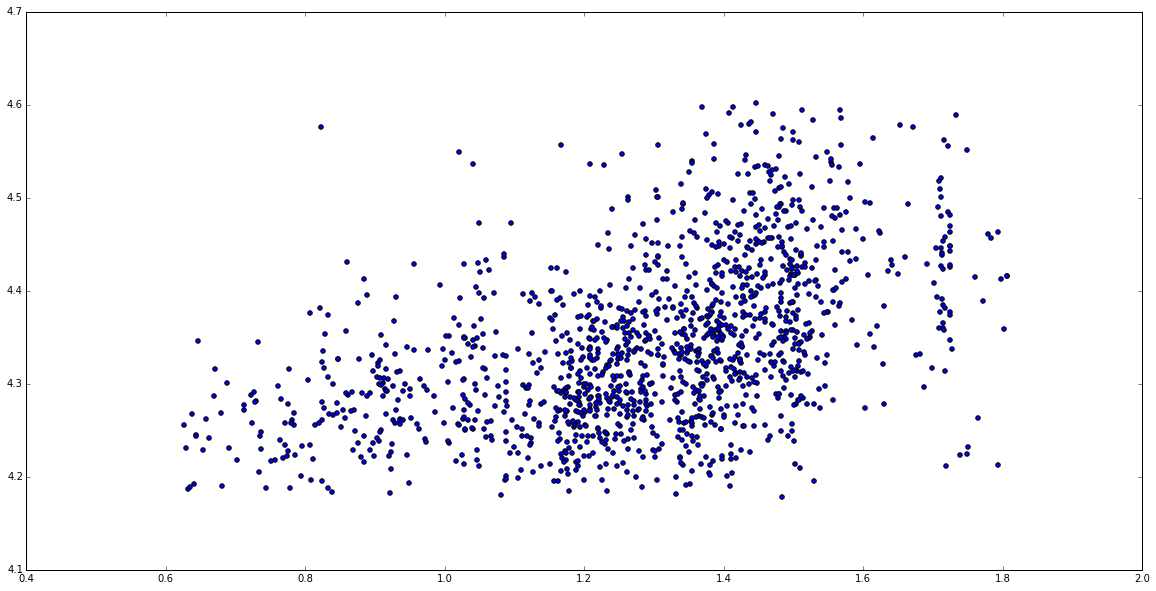

In [13]:
x = df2['NgPrice']
y = df2['meanPrice']
plt.scatter(x,y)
plt.plot(x=x)

In [16]:

from sklearn.cross_validation import train_test_split
from sklearn import grid_search
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy import stats
from sklearn.linear_model import LinearRegression


# Outlier Removal: Very low LMP
df2 = df.copy()
df2 = df2[df2['meanPrice'] > 15]


# Log Transform
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate by tiny amount to avoid np.log(0)
df2['Northern Appalachia'] = np.log(df2['Northern Appalachia'] + 0.001)
df2['Illinois Basin'] = np.log(df2['Illinois Basin'] + 0.001)
df2['Uinta Basin'] = np.log(df2['Uinta Basin'] + 0.001)
df2['Powder River Basin'] = np.log(df2['Uinta Basin'] + 0.001)
df2['Central Appalachia'] = np.log(df2['Central Appalachia'] + 0.001)


# Outlier Removal: 2-sd
df2 = df2[(np.abs(stats.zscore(df2['meanPrice'])) < 2)]


In [10]:
df2

,meanPrice,Central Appalachia,Northern Appalachia,Illinois Basin,Powder River Basin,Uinta Basin,NgPrice,windGenerationMWh,Central ActualLoad (MWh),East ActualLoad (MWh),MISO ActualLoad (MWh),Midwest ISO ActualLoad (MWh),North ActualLoad (MWh),South ActualLoad (MWh),West ActualLoad (MWh)
2009-07-06,4.358577,3.978435,3.937041,3.786460,1.360395,3.797734,1.210452,325.927083,21654.299167,28127.989583,0,62493.192500,0,0,12710.903750
2009-07-07,4.313575,3.981549,3.953165,3.786460,1.360395,3.797734,1.193922,511.056250,22956.574167,27699.694167,0,63508.234167,0,0,12851.965833
2009-07-08,4.253098,3.981549,3.953165,3.786460,1.360395,3.797734,1.193489,728.637083,22402.212500,27335.640833,0,62295.661250,0,0,12557.807917
2009-07-09,4.280853,3.981549,3.953165,3.786460,1.360395,3.797734,1.193056,1716.773333,23165.527500,28635.972917,0,64392.903333,0,0,12591.402917
2009-07-10,4.291526,3.981549,3.953165,3.786460,1.360395,3.797734,1.192623,837.547917,23676.907917,29816.782083,0,66701.584583,0,0,13207.894583
2009-07-11,4.286227,3.981549,3.953165,3.786460,1.360395,3.797734,1.192189,674.837083,21848.576667,27596.232917,0,60695.579583,0,0,11250.770000
2009-07-12,4.211572,3.981549,3.953165,3.786460,1.360395,3.797734,1.191756,495.702917,20356.957083,24671.105833,0,55857.834167,0,0,10829.771250
2009-07-13,4.342863,3.981549,3.953165,3.786460,1.360395,3.797734,1.191322,638.280417,22802.421250,28374.796250,0,63736.003333,0,0,12558.785833
2009-07-14,4.258528,3.981549,3.953165,3.786460,1.360395,3.797734,1.190888,2185.019167,22342.157083,28381.067500,0,63360.878750,0,0,12637.654167
2009-07-15,4.296287,3.981549,3.953165,3.792918,1.360395,3.797734,1.199104,2541.582917,23337.224583,30641.311250,0,66504.448333,0,0,12525.912500


In [28]:
import statsmodels.formula.api as smf


df3 = df2['meanPrice']
df3 = pd.DataFrame(df3)
#df3['ng'] = df2['NgPrice']

#lm = smf.ols(formula='meanPrice ~ NgPrice + "Midwest ISO ActualLoad (MWh)"', data=df2).fit()

#lm.params
df2['NgPrice']
# print intercept and coefficients
#print lm.intercept_
#print lm.coef_

2009-07-06    1.210452
2009-07-07    1.193922
2009-07-08    1.193489
2009-07-09    1.193056
2009-07-10    1.192623
2009-07-11    1.192189
2009-07-12    1.191756
2009-07-13    1.191322
2009-07-14    1.190888
2009-07-15    1.199104
2009-07-16    1.207253
2009-07-18    1.223355
2009-07-19    1.231310
2009-07-20    1.239202
2009-07-21    1.247032
2009-07-22    1.247443
2009-07-23    1.247853
2009-07-24    1.248263
2009-07-25    1.248673
2009-07-26    1.249083
2009-07-27    1.249492
2009-07-28    1.249902
2009-07-29    1.251538
2009-07-30    1.253171
2009-07-31    1.254802
2009-08-01    1.256430
2009-08-03    1.259678
2009-08-04    1.261298
2009-08-05    1.261702
2009-08-06    1.262107
                ...   
2013-08-03    1.225455
2013-08-04    1.219987
2013-08-05    1.214489
2013-08-06    1.208960
2013-08-07    1.208960
2013-08-08    1.208960
2013-08-09    1.208960
2013-08-10    1.208960
2013-08-11    1.208960
2013-08-12    1.208960
2013-08-13    1.208960
2013-08-14    1.208960
2013-08-15 

In [26]:
df3.head()

,meanPrice
2009-07-06 00:00:00,4.358577
2009-07-07 00:00:00,4.313575
2009-07-08 00:00:00,4.253098
2009-07-09 00:00:00,4.280853
2009-07-10 00:00:00,4.291526
